In [3]:
require 'loadcaffe'
require 'image'

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 

prototxt_name = '/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights'

--prototxt_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/deploy.prototxt'
--binary_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/bvlc_alexnet.caffemodel'

print '==> Loading network'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'continuum_of_coverage_general_surveillance_5.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights


MODULE data UNDEFINED


conv1: 96 3 11 11
conv2: 256 48 5 5
conv3: 384 256 3 3


conv4: 384 192 3 3


conv5: 256 192 3 3
fc6: 1 1 9216 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading image and imagenet mean	


==> Preprocessing	


In [2]:
local SpatialDeconvolution, parent = torch.class('cudnn.SpatialDeconvolution', 'cudnn.SpatialConvolution')
require'cutorch'

function SpatialDeconvolution:__init( convLayer, reconstruction_size )
    assert( torch.typename(convLayer) == 'cudnn.SpatialConvolution', 'Input should be cudnn.SpatialConvolution()')
    parent.__init(self, convLayer.nOutputPlane, convLayer.nInputPlane, convLayer.kW, convLayer.kH, convLayer.dW, 
                  convLayer.dH, convLayer.padW, convLayer.padH, convLayer.groups)
    self:reset() 
    self.reconstruction_size = reconstruction_size
    self.weight=convLayer.weight
    self.gradWeight=convLayer.gradWeight    
end



function SpatialDeconvolution:updateOutput(input)
    local deconv1_fm = torch.CudaTensor( self.nInputPlane, self.nOutputPlane, self.reconstruction_size, 
                                         self.reconstruction_size):zero():cuda()
    local deconv1 = cudnn.SpatialConvolution(1, 1, self.kW, self.kH, 1, 1, 
                                             math.floor(self.kW/2), math.floor(self.kH/2), self.group):cuda()
    
    local conv_scat_fm = torch.zeros(self.nInputPlane, self.reconstruction_size, self.reconstruction_size):cuda()
    local stride_size = self.dH
    local padding_size = (self.reconstruction_size - (input:size(2) * stride_size))/2
    
    local n=input:size(3)
    local x=stride_size

    -- Scatter     contributed by TingFan
    local idx=torch.LongTensor(n*n,1):cuda()
    local counter=1;
    for i=1,n*x,x do
        for j=1,n*x,x do     
            idx[counter]=(i-1+padding_size)*(n*x+padding_size*2) + j + padding_size
            counter=counter+1;
        end
    end

    local total_size = (n*x+padding_size*2)*(n*x+padding_size*2)
    for i=1,self.nInputPlane do
        local m=torch.zeros(n*x+padding_size*2,n*x+padding_size*2):cuda()
        m:view(total_size,1):scatter(1,idx,input[i]:view(n*n,1))
        conv_scat_fm[i] = m
    end    
          
    -- Deconv
    for i=1, self.nInputPlane do
        for j=1, self.nOutputPlane do
            local fm = conv_scat_fm[i]

            deconv1.weight = self.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous()
            local deconv_result = deconv1:forward(fm:view(1, self.reconstruction_size, self.reconstruction_size)):cuda()

            -- BGR to RGB
            if self.nOutputPlane==3 then
                deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
            else
                deconv1_fm[{ {i}, {j}, {}, {} }] = deconv_result
            end
            
        end
    end

    cutorch.synchronize()    
    return deconv1_fm
end 




In [3]:
deconv1 = cudnn.SpatialDeconvolution(net:get(1), I:size(2) )

==> Time elapsed: 0.1705048084259 seconds	


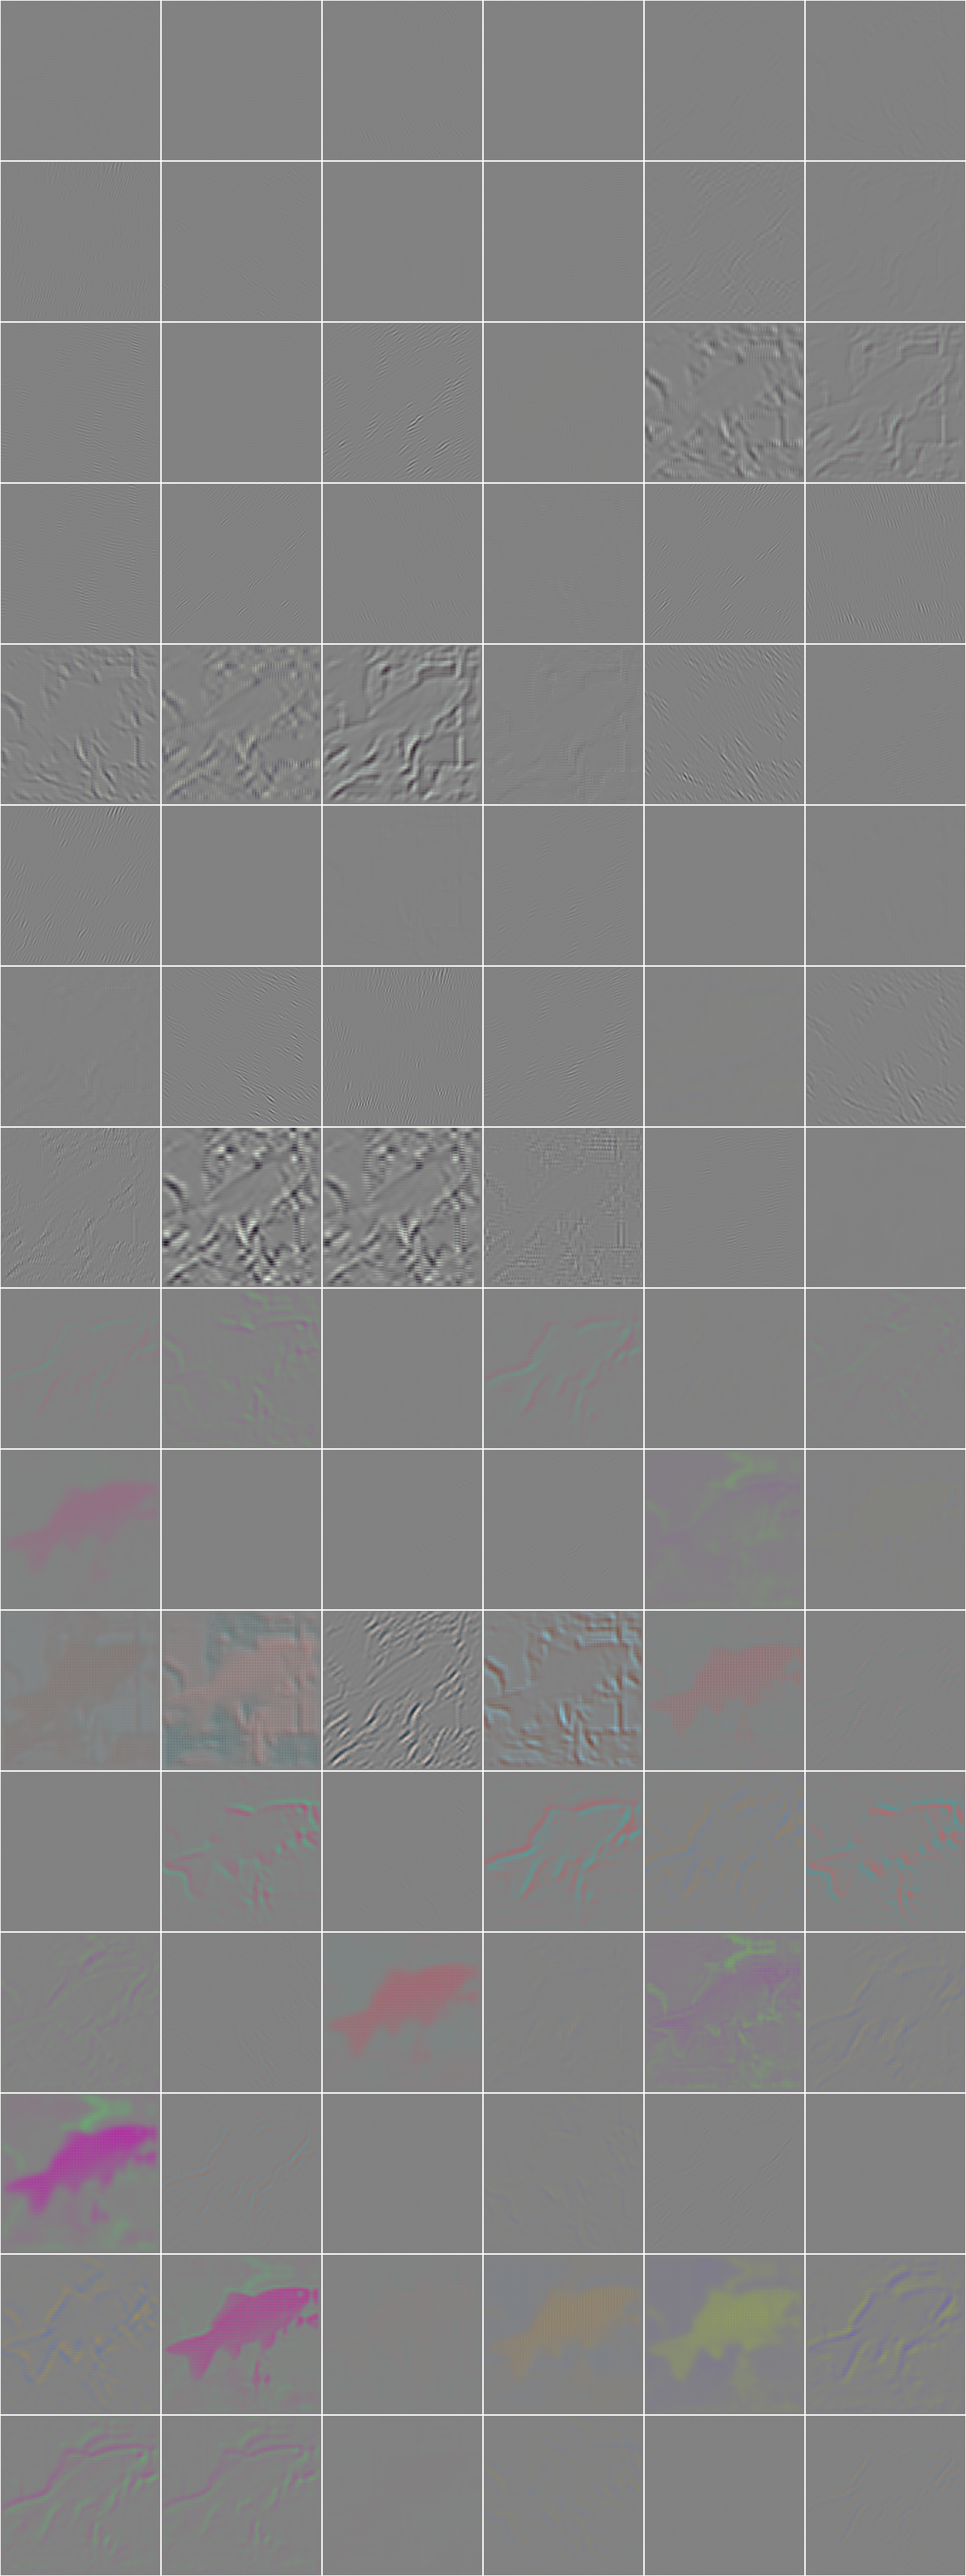

In [4]:
conv1 = net:get(1)
conv1_fm = conv1:forward(I:cuda())
--itorch.image(conv1_fm:float())
timer = torch.Timer()

-- conv1_scat_fm = torch.zeros(96, I:size(2), I:size(3)):cuda()
-- stride_size = 4
-- padding_size = (I:size(2) - (conv1_fm:size(2) * stride_size))/2

-- n=conv1_fm:size(3);
-- x=stride_size

-- idx=torch.LongTensor(n*n,1):cuda();
-- local counter=1;
-- for i=1,n*x,x do
--     for j=1,n*x,x do     
--         idx[counter]=(i-1+padding_size)*(n*x+padding_size*2) + j + padding_size
--         counter=counter+1;
--     end
-- end

-- local total_size = (n*x+padding_size*2)*(n*x+padding_size*2)
-- for i=1,96 do
--     local m=torch.zeros(n*x+padding_size*2,n*x+padding_size*2):cuda()
--     m:view(total_size,1):scatter(1,idx,conv1_fm[i]:view(n*n,1))
--     conv1_scat_fm[i] = m
-- end    
    
-- cutorch.synchronize()

deconv1_fm = deconv1:forward(conv1_fm) 
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
itorch.image(deconv1_fm:float())

In [4]:
print(net)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> output]
  (1): cudnn.SpatialConvolution(3 -> 96, 11x11, 4,4)
  (2): cudnn.ReLU
  (3): cudnn.SpatialMaxPooling
  (4): inn.SpatialCrossResponseNormalization
  (5): cudnn.SpatialConvolution(96 -> 256, 5x5, 1,1, 2,2)
  (6): cudnn.ReLU
  (7): cudnn.SpatialMaxPooling
  (8): inn.SpatialCrossResponseNormalization
  (9): cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
  (10): cudnn.ReLU
  (11): cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
  (12): cudnn.ReLU
  (13): cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
  (14): cudnn.ReLU
  (15): cudnn.SpatialMaxPooling
  (16): nn.View
  (17): nn.Linear(9216 -> 4096)
  (18): cudnn.ReLU
  (19): nn.Dropout(0.500000)
  (20): nn.Linear(4096 -> 4096)
  (21): cudnn.ReLU
  (22): nn.Dropout(0.500000)
  (23): nn.Linear(4096 -> 1000)
  (24)

   dW : 4
          nOutputPlane : 96
          padH : 0
          kH : 11
          finput : CudaTensor - empty
          weight : CudaTensor - size: 96x3x11x11
          train : false
          gradWeight : CudaTensor - size: 96x3x11x11
          fgradInput : CudaTensor - empty
          kW : 11
          bias : CudaTensor - size: 96
          gradBias : CudaTensor - size: 96
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      3 : 
        cudnn.SpatialMaxPooling
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty


          iSize : LongStorage - size: 4
          mode : CUDNN_POOLING_MAX
          train : false
          kH : 3
          ceil_mode : true
          output : CudaTensor - empty
          padW : 0
          kW : 3
        }
      4 : 
        inn.SpatialCrossResponseNormalization
        {
          scale : CudaTensor - empty
          alpha : 0.0001
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          size : 5
          k : 1
          beta : 0.75
        }
      5 : 
        cudnn.SpatialConvolution(96 -> 256, 5x5, 1,1, 2,2)
        {
          padW : 2
          nInputPlane : 96
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
       

   groups : 2
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 2
          kH : 5
          finput : CudaTensor - empty
          weight : CudaTensor - size: 256x48x5x5
          train : false
          gradWeight : CudaTensor - size: 256x48x5x5
          fgradInput : CudaTensor - empty
          kW : 5
          bias : CudaTensor - size: 256
          gradBias : CudaTensor - size: 256
        }
      6 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      7 : 
        cudnn.SpatialMaxPooling
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty
 

         iSize : LongStorage - size: 4
          mode : CUDNN_POOLING_MAX
          train : false
          kH : 3
          ceil_mode : true
          output : CudaTensor - empty
          padW : 0
          kW : 3
        }
      8 : 
        inn.SpatialCrossResponseNormalization
        {
          scale : CudaTensor - empty
          alpha : 0.0001
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          size : 5
          k : 1
          beta : 0.75
        }
      9 : 
        cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          finput : CudaTensor - empty
          weight : CudaTensor - size: 384x256x3x3
          train : fa

  gradWeight : CudaTensor - size: 384x256x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 384
          gradBias : CudaTensor - size: 384
        }
      10 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      11 : 
        cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 2
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          finput : CudaTensor - empty
          weight : CudaTensor - size: 384x192x3x3
          train : false
          gradWeight : CudaTensor - size: 384x192x3x3
          fgradInput : CudaTensor - empty
       

          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      13 : 
        cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 2
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          finput : CudaTensor - empty
          weight : CudaTensor - size: 256x192x3x3
          train : false
          gradWeight : CudaTensor - size: 256x192x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 256
          gradBias : CudaTensor - size: 256
        }
      14 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      

      mode : CUDNN_POOLING_MAX
          train : false
          kH : 3
          ceil_mode : true
          output : CudaTensor - empty
          padW : 0
          kW : 3
        }
      16 : 
        nn.View
        {
          numInputDims : 3
          size : LongStorage - size: 1
          train : false
          numElements : 1
        }
      17 : 
        nn.Linear(9216 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x9216
          train : false
          bias : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x9216
          output : CudaTensor - empty
        }
      18 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      19 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          n


          p : 0.5
          gradInput : CudaTensor - empty
          output : CudaTensor - empty
        }
      20 : 
        nn.Linear(4096 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x4096
          train : false
          bias : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x4096
          output : CudaTensor - empty
        }
      21 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      22 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : CudaTensor - empty
          train : false
          p : 0.5
          gradInput : CudaTensor - empty
          output : CudaTensor - empty
        }
      23 : 
        nn.Linear(4096 -> 1000)
        {
          gradBias : CudaTen

          bias : CudaTensor - size: 1000
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 1000x4096
          output : CudaTensor - empty
        }
      24 : 
        nn.SoftMax
        {
          gradInput : CudaTensor - empty
          train : false
          output : CudaTensor - empty
        }
    }
  train : false
  output : CudaTensor - empty
}
